<a href="https://colab.research.google.com/github/dlwub/Final_Project_AIMS/blob/main/Final_Project_SVR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import ipywidgets
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from scipy import stats

In [ ]:
# Import necessary libraries
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance

## Support Vector Regression (SVR)



In [ ]:
mergedData = pd.read_csv("/content/mergedData.csv")

### RMSE on train and test sets

In [ ]:
def get_train_test_set(duration):
  dataset = mergedData.drop(mergedData.columns[0], axis=1)
  values = dataset.values
  X, y = values[:, :-1], values[:, -1:]
  scaler_x = MinMaxScaler()
  scaled_x = scaler_x.fit_transform(X)
  train_size = mergedData.shape[0] - duration
  X_train = scaled_x[:train_size, :]
  X_test = scaled_x[train_size:, :]
  y_train = y[:train_size, :]
  y_test = y[train_size:, :]
  return X_train, y_train, X_test, y_test, scaler_x

In [ ]:
def get_mae_rmse(model, duration):
  X_train, y_train, X_test, y_test, scaler_x = get_train_test_set(duration)
  model.fit(X_train, y_train.ravel())
  X_pred = model.predict(X_train)
  X_pred = X_pred.reshape(-1, 1)
  y_pred = model.predict(X_test)

  y_pred = y_pred.reshape(-1, 1)
  y_test = y_test.reshape(-1, 1)

  mae_train = mean_absolute_error(y_train, X_pred)
  mae_test = mean_absolute_error(y_test, y_pred)
  rmse_train = np.sqrt(mean_squared_error(y_train, X_pred))
  rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))

  return mae_train, mae_test, rmse_train, rmse_test

In [ ]:
def get_best_params(kernel, X_train, y_train):
  param_grid = {
    'gamma': [0.001, 0.01, 0.1, 1],
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 0.2, 0.5]
  }

  svr = SVR(kernel=kernel)

  # Perform grid search with cross-validation
  grid_search = GridSearchCV(estimator=svr, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
  grid_search.fit(X_train, y_train.ravel())
  return grid_search.best_params_

### Feature Importance

In [ ]:
def plot_importance_graph(model, kernel):
  results = permutation_importance(model, X_train, y_train, scoring='neg_mean_squared_error')
  importance = results.importances_mean
  importance_sum = np.sum(np.abs(importance))
  importance_ = importance/importance_sum
  indices = np.argsort(importance_)
  plt.barh(range(X_train.shape[1]), importance_[indices])
  plt.xticks(fontsize=12)
  plt.yticks(range(X_train.shape[1]), mergedData.columns[1:-1][indices], fontsize=12)
  plt.xlabel('Feature Importance', fontsize=14)
  plt.ylabel('Features', fontsize=14)
  plt.show()

### Plotting the curves

In [ ]:
def get_predicted_values(model, duration):
  X_train, y_train, X_test, y_test = get_train_test_set(duration)[0:4]
  model.fit(X_train, y_train.ravel())
  y_pred = model.predict(X_test).reshape(-1, 1)
  y_test = y_test.reshape(-1, 1)
  return y_pred, y_test

In [ ]:
# Plot predicted vs real values with dates on the x-axis
def plot_SVR(kernel, duration):
  split_index = mergedData.shape[0] - duration
  test_date = mergedData.iloc[split_index:, 0]
  model = model1 if kernel == 'rbf' else model2
  y_pred, y_test = get_predicted_values(model, duration)
  plt.figure(figsize=(10, 5))
  plt.plot(test_date, y_test, label='Real Values', marker='o')
  plt.plot(test_date, y_pred, label='Predicted Values', marker='x')
  plt.xlabel('Dates', fontsize=14)
  plt.ylabel('CPI', fontsize=14)
  #plt.title('Predicted vs Real Values (SVR %s kernel - %s prediction)' %(kernel, "test" if duration > 24 else "%d months" %duration))
  plt.xticks(rotation=45)
  plt.xticks(range(0, len(test_date), 6), test_date[::6], fontsize=12)
  plt.yticks(fontsize=12)
  results = {}
  mae = float(format(mean_absolute_error(y_test, y_pred.ravel()),'.2f'))
  rmse = float(format(np.sqrt(mean_squared_error(y_test, y_pred.ravel())),'.2f'))
  results[duration] = {'MAE': mae, 'RMSE': rmse}
  print(results)
  plt.legend()
  plt.grid(True)
  plt.tight_layout()
  plt.show()

### Train test sets

In [ ]:
X_train, y_train, X_test, y_test, scaler_x = get_train_test_set(int(mergedData.shape[0]*0.2))

### Models

In [ ]:
best_params_rbf = get_best_params('rbf', X_train, y_train)
model1 = SVR(kernel='rbf', gamma=best_params_rbf['gamma'], C=best_params_rbf['C'], epsilon = best_params_rbf['epsilon'])

In [ ]:
best_params_rbf

{'C': 100, 'epsilon': 0.01, 'gamma': 0.01}

In [ ]:
best_params_linear = get_best_params('linear', X_train, y_train)
model2 = SVR(kernel='linear', gamma=best_params_linear['gamma'], C=best_params_linear['C'], epsilon = best_params_linear['epsilon'])

In [ ]:
best_params_linear

{'C': 100, 'epsilon': 0.1, 'gamma': 0.001}

## RBF kernel

In [ ]:
y_pred, y_test = get_predicted_values(model1, int(mergedData.shape[0]*0.2))

In [ ]:
df = pd.DataFrame({'Predicted value': y_pred.flatten(), 'Real Value': y_test.flatten()})
df

,Predicted value,Real Value
0,106.515052,108.968156
1,104.701704,109.643299
2,104.680964,110.858557
3,105.695818,111.398672
4,106.061521,111.533701
...,...,...
66,129.662008,140.834927
67,130.466542,143.130415
68,131.142533,143.535501
69,132.601901,143.670530


In [ ]:
mae_train, mae_test, rmse_train, rmse_test = get_mae_rmse(model1, int(mergedData.shape[0]*0.2))
print("Mean Absolute Error on Training Data: {:.2f}".format(mae_train))
print("Mean Absolute Error on Testing Data: {:.2f}".format(mae_test))
print("Root Mean Squared Error on Training Data: {:.2f}".format(rmse_train))
print("Root Mean Squared Error on Testing Data: {:.2f}".format(rmse_test))

Mean Absolute Error on Training Data: 1.59
Mean Absolute Error on Testing Data: 7.80
Root Mean Squared Error on Training Data: 2.02
Root Mean Squared Error on Testing Data: 8.13


### Feature Importance in rbf kernel

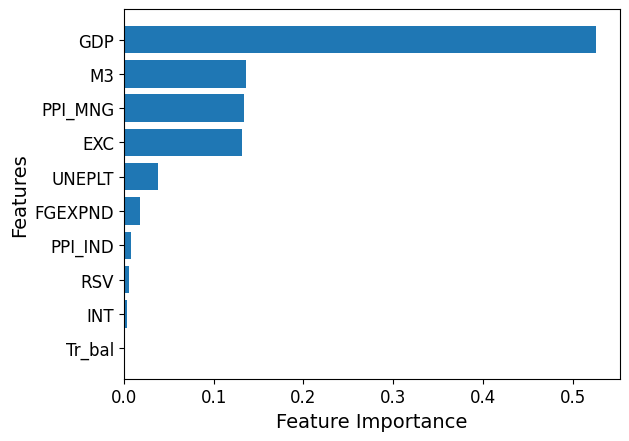

In [ ]:
plot_importance_graph(model1, 'RBF')

{71: {'MAE': 7.8, 'RMSE': 8.13}}


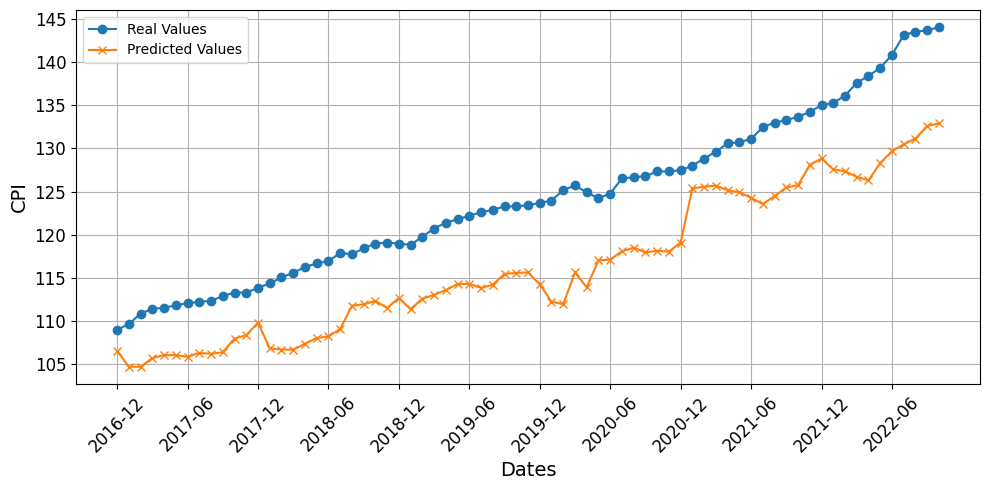

In [ ]:
plot_SVR('rbf', int(mergedData.shape[0]*0.2))

## Linear kernel

In [ ]:
y_pred, y_test = get_predicted_values(model2, int(mergedData.shape[0]*0.2))

In [ ]:
df = pd.DataFrame({'Predicted value': y_pred.flatten(), 'Real Value': y_test.flatten()})
df

,Predicted value,Real Value
0,107.838636,108.968156
1,108.244014,109.643299
2,108.976744,110.858557
3,109.645562,111.398672
4,110.319666,111.533701
...,...,...
66,146.698084,140.834927
67,149.399575,143.130415
68,148.584597,143.535501
69,149.827461,143.670530


In [ ]:
mae_train, mae_test, rmse_train, rmse_test = get_mae_rmse(model2, int(mergedData.shape[0]*0.2))
print("Mean Absolute Error on Training Data: {:.2f}".format(mae_train))
print("Mean Absolute Error on Testing Data: {:.2f}".format(mae_test))
print("Root Mean Squared Error on Training Data: {:.2f}".format(rmse_train))
print("Root Mean Squared Error on Testing Data: {:.2f}".format(rmse_test))

Mean Absolute Error on Training Data: 0.85
Mean Absolute Error on Testing Data: 3.36
Root Mean Squared Error on Training Data: 1.18
Root Mean Squared Error on Testing Data: 4.51


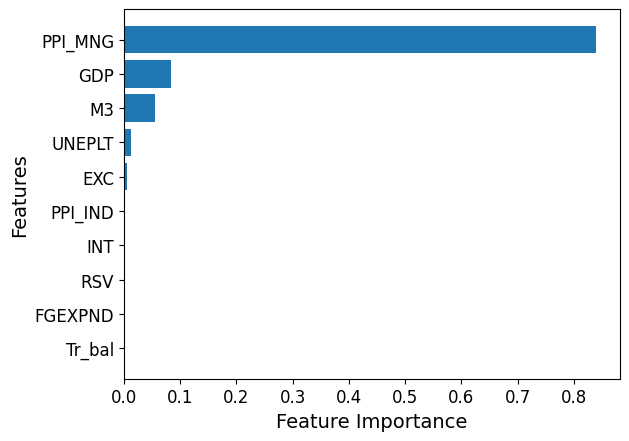

In [ ]:
plot_importance_graph(model2, 'linear')

{71: {'MAE': 3.36, 'RMSE': 4.51}}


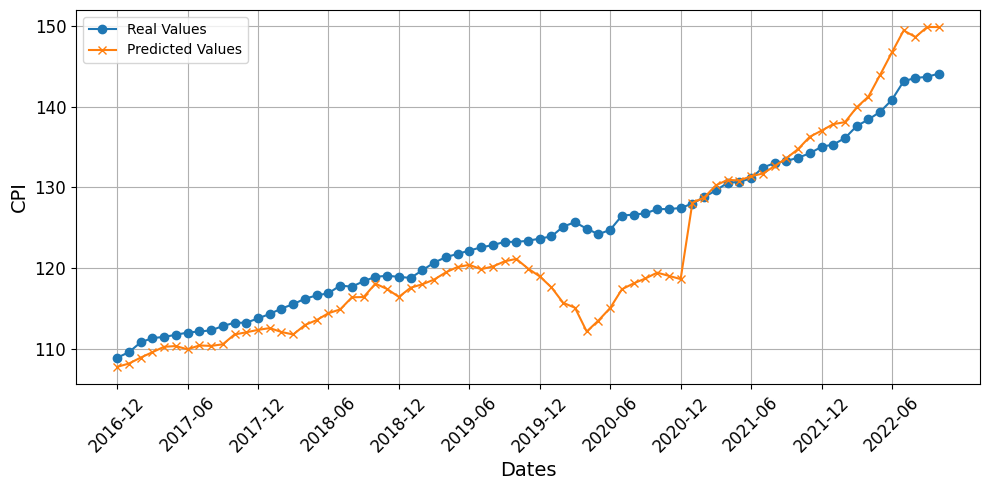

In [ ]:
plot_SVR('linear', int(mergedData.shape[0]*0.2))

### Forecast (Interactive plot)

In [ ]:
ipywidgets.interact(plot_SVR, kernel=['linear', 'rbf'], duration=ipywidgets.SelectionSlider(options=[1, 3, 6, 12, 24]))

interactive(children=(Dropdown(description='kernel', options=('linear', 'rbf'), value='linear'), SelectionSlid…

<function __main__.plot_SVR(kernel, duration)>